# 1. Setup and Data Loading

In [1]:
librarian::shelf(tidyverse, tidymodels, kableExtra, patchwork, 
                skimr, gridExtra, janitor, corrplot, scales,
                GGally, car, forcats, performance, glmmTMB, 
                splines, mgcv, DHARMa, zoo, ggpubr, ggridges,
                caret, rstatix, Metrics, mice, missRanger, ranger)

In [2]:
df <- read_csv("data/weatherAUS.csv")

Rows: 145460 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (6): Location, WindGustDir, WindDir9am, WindDir3pm, RainToday, RainTom...
dbl  (16): MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustSpeed,...
date  (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# 2. Utility Functions

In [3]:
# Function to display missing values
missing_val <- function(df){
  missing_tab <- df %>% 
    summarise(across(everything(), ~mean(is.na(.)) * 100)) %>% 
    pivot_longer(everything(), names_to = "column", values_to = "pct_missing") %>% 
    arrange(desc(pct_missing))
  
  return(missing_tab %>% kable())
}

# Function to check multicollinearity
mc_check <- function(data){
  vif_check <- lm(rainfall ~ ., data = data)
  test_collinearity <- check_collinearity(vif_check)
  return(test_collinearity)
}

# Function to select model features
select_model_features <- function(data, keep_location = TRUE){
  cols_to_drop = c(
    "month", "day", "day_of_year", "date",
    "temp9am", "temp3pm", "min_temp", "max_temp",
    "pressure3pm", "pressure9am",
    "cloud3pm", "cloud9am",
    "dewpoint_3pm", "wind_dir3pm", "wind_speed3pm",
    "wind_gust_dir", "wind_gust_speed", "wind_speed9am",
    "wind_dir9am", "wind9am_rad", "gust_rad",
    "moisture_index",
    "rain_today"
  )
  
  if (!keep_location){
    cols_to_drop <- c(cols_to_drop, "location")
  }
  imp_flags <- names(data)[grepl("_imp_flagged$", names(data))]
  cols_to_drop <- c(cols_to_drop, imp_flags)
  
  data <- data %>% 
    select(-any_of(cols_to_drop)) %>%
    ungroup()
  
  return(data)
}

# Function to scale data
scale_data <- function(data){
  df_scaled <- data %>%
    mutate(across(
      .cols = where(is.numeric) & !c("rainfall"), 
      .fns = scale
    ))
  
  return(df_scaled)
}

# 3. Data Cleaning and Preprocessing

In [4]:
df_clean <- df %>%
  clean_names() %>%
  mutate(
    date = as.Date(date),
    month = as.factor(month(date)),
    day = as.factor(wday(date, label = TRUE))
  ) %>%
  filter(!is.na(rainfall))

df_clean %>% head() %>% kable()
df_clean %>% tail() %>% kable()



|date       |location | min_temp| max_temp| rainfall| evaporation| sunshine|wind_gust_dir | wind_gust_speed|wind_dir9am |wind_dir3pm | wind_speed9am| wind_speed3pm| humidity9am| humidity3pm| pressure9am| pressure3pm| cloud9am| cloud3pm| temp9am| temp3pm|rain_today |rain_tomorrow |month |day |
|:----------|:--------|--------:|--------:|--------:|-----------:|--------:|:-------------|---------------:|:-----------|:-----------|-------------:|-------------:|-----------:|-----------:|-----------:|-----------:|--------:|--------:|-------:|-------:|:----------|:-------------|:-----|:---|
|2017-06-20 |Uluru    |      3.5|     21.8|        0|          NA|       NA|E             |              31|ESE         |E           |            15|            13|          59|          27|      1024.7|      1021.2|       NA|       NA|     9.4|    20.9|No         |No            |6     |Tue |
|2017-06-21 |Uluru    |      2.8|     23.4|        0|          NA|       NA|E             |              31|SE      

# 4. Exploratory Data Analysis

## 4.1 Temporal Distribution

In [5]:
# Day Distribution
day_tab <- df_clean %>% 
  filter(rainfall > 0) %>% 
  tabyl(day) %>% 
  adorn_pct_formatting() %>% 
  arrange(desc(n))
print(day_tab)

# Month distribution
month_tab <- df_clean %>% 
  filter(rainfall > 0) %>% 
  tabyl(month) %>% 
  adorn_pct_formatting() %>% 
  arrange(desc(n))
print(month_tab)

# Cross-tabulation
cat("\nCross-tabulation: Month vs Day:\n")
cross_tab <- df_clean %>% 
  filter(rainfall > 0) %>% 
  tabyl(month, day) %>% 
  adorn_totals(c("row", "col"))
print(cross_tab)

 day    n percent
 Tue 7508   14.7%
 Mon 7480   14.6%
 Fri 7378   14.4%
 Wed 7342   14.4%
 Thu 7314   14.3%
 Sat 7057   13.8%
 Sun 7040   13.8%
 month    n percent
     6 5448   10.7%
     7 5250   10.3%
     5 4937    9.7%
     8 4704    9.2%
     3 4444    8.7%
     9 4234    8.3%
     4 4001    7.8%
    10 3770    7.4%
    11 3760    7.4%
     1 3702    7.2%
    12 3562    7.0%
     2 3307    6.5%

Cross-tabulation: Month vs Day:
 month  Sun  Mon  Tue  Wed  Thu  Fri  Sat Total
     1  536  570  514  482  493  567  540  3702
     2  480  530  469  466  443  471  448  3307
     3  636  645  639  592  662  644  626  4444
     4  578  597  566  604  579  515  562  4001
     5  710  722  765  714  678  681  667  4937
     6  766  801  804  797  760  753  767  5448
     7  694  717  728  796  773  818  724  5250
     8  612  702  694  679  689  687  641  4704
     9  516  571  616  639  648  659  585  4234
    10  507  606  579  550  517  456  555  3770
    11  556  526  554  480  538  57

## 4.2 Missing Values Analysis

In [6]:
print(paste("Total Missing values:", sum(is.na(df_clean))))
missing_val(df_clean)

[1] "Total Missing values: 314146"




|column          | pct_missing|
|:---------------|-----------:|
|sunshine        |  47.6937250|
|evaporation     |  42.5375706|
|cloud3pm        |  39.9960619|
|cloud9am        |  37.5044832|
|pressure3pm     |   9.8404349|
|pressure9am     |   9.8031632|
|wind_dir9am     |   6.8840147|
|wind_gust_dir   |   6.8390073|
|wind_gust_speed |   6.7968129|
|wind_dir3pm     |   2.6716081|
|humidity3pm     |   2.5527606|
|temp3pm         |   1.9310966|
|wind_speed3pm   |   1.8614758|
|humidity9am     |   1.0928347|
|rain_tomorrow   |   0.9929746|
|wind_speed9am   |   0.7672347|
|temp9am         |   0.4817193|
|min_temp        |   0.3424778|
|max_temp        |   0.3305227|
|date            |   0.0000000|
|location        |   0.0000000|
|rainfall        |   0.0000000|
|rain_today      |   0.0000000|
|month           |   0.0000000|
|day             |   0.0000000|

## 4.3 Target Variable Statistics

In [7]:
rainfall_stats <- df_clean %>% 
  summarise(
    n = n(),
    mean = mean(rainfall),
    median = median(rainfall),
    sd = sd(rainfall),
    min = min(rainfall),
    max = max(rainfall),
    q25 = quantile(rainfall, 0.25),
    q75 = quantile(rainfall, .75),
    iqr = IQR(rainfall),
    n_zeros = sum(rainfall == 0),
    pct_zeros = mean(rainfall == 0) * 100,
    n_large = sum(rainfall > 100),
    pct_large = mean(rainfall > 100) * 100,
    skewness = moments::skewness(rainfall),
    kurtosis = moments::kurtosis(rainfall)
  )

t(rainfall_stats) %>% kable()



|          |             |
|:---------|------------:|
|n         | 1.421990e+05|
|mean      | 2.360918e+00|
|median    | 0.000000e+00|
|sd        | 8.478060e+00|
|min       | 0.000000e+00|
|max       | 3.710000e+02|
|q25       | 0.000000e+00|
|q75       | 8.000000e-01|
|iqr       | 8.000000e-01|
|n_zeros   | 9.108000e+04|
|pct_zeros | 6.405108e+01|
|n_large   | 1.510000e+02|
|pct_large | 1.061892e-01|
|skewness  | 9.836122e+00|
|kurtosis  | 1.811458e+02|

In [8]:
rain_check <- df_clean %>%
  summarise(
    total_days = n(),
    dry_days = sum(rainfall == 0),
    rainy_days = sum(rainfall > 0),
    zero_inflation_pct = (dry_days / total_days) * 100
  )

rain_check %>% kable()



| total_days| dry_days| rainy_days| zero_inflation_pct|
|----------:|--------:|----------:|------------------:|
|     142199|    91080|      51119|           64.05108|

## 4.4 Correlation Analysis


In [9]:
numeric_cols <- df_clean %>% 
  select(where(is.numeric)) %>% 
  names()

numeric_cols <- numeric_cols[numeric_cols != "rainfall"]

cors <- df_clean %>%
  rstatix::cor_test(vars = "rainfall", vars2 = numeric_cols, method = "spearman") %>%
  filter(!is.na(cor)) %>%
  arrange(desc(abs(cor))) %>%
  dplyr::select(var2, cor, p) %>%
  mutate(interpretation = case_when(
    abs(cor) < 0.1 ~ "Negligible",
    abs(cor) < 0.3 ~ "Small",
    abs(cor) < 0.5 ~ "Moderate",
    TRUE ~ "Large"
  ))

cors

Warning message:
Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(numeric_cols)

  # Now:
  data %>% select(all_of(numeric_cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This warning is displayed once per session.
Call ]8;;x-r-run:lifecycle::last_lifecycle_warnings()lifecycle::last_lifecycle_warnings()]8;; to see where this warning was
generated. 


# A tibble: 15 × 4
   var2               cor         p interpretation
   <chr>            <dbl>     <dbl> <chr>         
 1 humidity9am      0.44  0         Moderate      
 2 humidity3pm      0.44  0         Moderate      
 3 sunshine        -0.4   0         Moderate      
 4 cloud9am         0.37  0         Moderate      
 5 cloud3pm         0.32  0         Moderate      
 6 evaporation     -0.31  0         Moderate      
 7 temp3pm         -0.31  0         Moderate      
 8 max_temp        -0.3   0         Moderate      
 9 pressure9am     -0.15  0         Small         
10 temp9am         -0.15  0         Small         
11 wind_gust_speed  0.13  0         Small         
12 wind_speed9am    0.083 1.02e-212 Negligible    
13 wind_speed3pm    0.068 5.65e-143 Negligible    
14 pressure3pm     -0.063 1.64e-114 Negligible    
15 min_temp         0.022 3.04e- 17 Negligible    

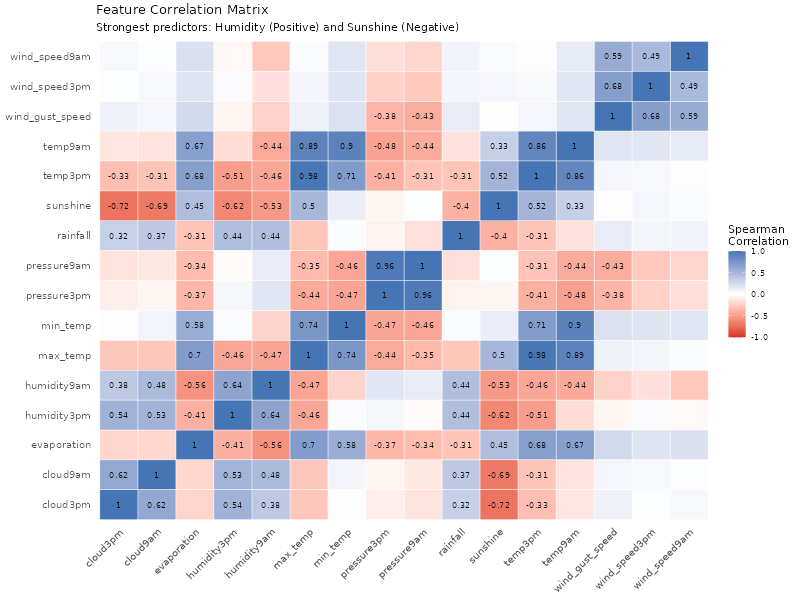

In [10]:
cor_matrix <- df_clean %>% 
  select(where(is.numeric)) %>% 
  cor(use = "pairwise.complete.obs", method = "spearman")

cor_melt <- cor_matrix %>% 
  as.data.frame() %>% 
  rownames_to_column(var = "Var1") %>% 
  pivot_longer(cols = -Var1, names_to = "Var2", values_to = "Correlation")

cor_melt %>% 
  ggplot(aes(x = Var1, y = Var2, fill = Correlation)) + 
  geom_tile(color = "white") +
  scale_fill_gradient2(
    low = "#D73027", mid = "white", high = "#4575B4", 
    midpoint = 0, limit = c(-1, 1), name = "Spearman\nCorrelation"
  ) +
  theme_minimal() + 
  theme(
    axis.text.x = element_text(angle = 45, vjust = 1, size = 10, hjust = 1), 
    axis.text.y = element_text(size = 10), 
    axis.title = element_blank(), 
    panel.grid.major = element_blank(), 
    legend.position = "right"
  ) +
  geom_text(
    data = filter(cor_melt, abs(Correlation) > 0.3), 
    aes(label = round(Correlation, 2)), 
    color = "black", size = 3
  ) +
  labs(
    title = "Feature Correlation Matrix", 
    subtitle = "Strongest predictors: Humidity (Positive) and Sunshine (Negative)"
  )

In [ ]:
# Test if humidity3pm is singnificantly stronger than the others
library(cocor)

cor_humidity <- cor.test(df_clean$rainfall, df_clean$humidity3pm, method = "kendall")
cor_sunshine <- cor.test(df_clean$rainfall, df_clean$sunshine, method = "kendall")

cor_humidity

In [ ]:
# Test if humidity3pm correlation is significantly stronger than others
library(cocor)

# Get correlations with rainfall
cor_humidity <- cor.test(df_clean$rainfall, dfn_clean$humidity3pm, 
                         method = "spearman")
cor_sunshine <- cor.test(df_clean$rainfall, df_clean$sunshine, 
                         method = "spearman")

# Compare two correlations from same sample
# Using Steiger's Z-test for dependent correlations
cocor.dep.groups.overlap(
  r.jk = cor_humidity$estimate,  # humidity-rainfall correlation
  r.jh = cor_sunshine$estimate,  # sunshine-rainfall correlation
  r.kh = cor(df_clean$humidity3pm, df_clean$sunshine, 
             use = "complete.obs", method = "spearman"),
  n = nrow(df_clean),
  alternative = "two.sided",
  test = "all",
  return.htest = TRUE
)

# For multiple comparisons, create a comparison table
top_predictors <- c("humidity3pm", "sunshine", "pressure9am", "cloud3pm")
comparison_results <- expand.grid(var1 = top_predictors, var2 = top_predictors) %>%
  filter(var1 != var2) %>%
  rowwise() %>%
  mutate(
    r1 = cor(df_clean$rainfall, df_clean[[var1]], 
             use = "complete.obs", method = "spearman"),
    r2 = cor(df_clean$rainfall, df_clean[[var2]], 
             use = "complete.obs", method = "spearman"),
    r12 = cor(df_clean[[var1]], df_clean[[var2]], 
              use = "complete.obs", method = "spearman")
  ) %>%
  ungroup()

# Apply Steiger's test to each pair
library(psych)
comparison_results <- comparison_results %>%
  rowwise() %>%
  mutate(
    z_score = r.test(n = nrow(df_clean), 
                     r12 = r1, 
                     r34 = r2, 
                     r13 = r12)$z,
    p_value = r.test(n = nrow(df_clean), 
                     r12 = r1, 
                     r34 = r2, 
                     r13 = r12)$p
  ) %>%
  arrange(p_value)

comparison_results %>% 
  select(var1, var2, r1, r2, z_score, p_value) %>%
  kable(digits = 4, caption = "Pairwise Comparison of Correlations with Rainfall")

Warning message:
In cor.test.default(df_clean$rainfall, df_clean$humidity3pm, method = "spearman") :
  Cannot compute exact p-value with ties
Warning message:
In cor.test.default(df_clean$rainfall, df_clean$sunshine, method = "spearman") :
  Cannot compute exact p-value with ties



Attaching package: ‘psych’

The following object is masked from ‘package:car’:

    logit

The following objects are masked from ‘package:scales’:

    alpha, rescale

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `z_score = r.test(n = nrow(df_clean), r12 = r1, r34 = r2,
  r13 = r12)$z`.
[36mℹ[39m In row 1.
[1mCaused by error in `r.test()`:[22m
[33m![39m You seem to be testing two dependent correlations, but have not specified the correlation(s)  correctly.

# 5. Data Imputation

In [11]:
clean_and_impute_weather <- function(df) {
  calc_mode <- function(x){
    ux <- unique(na.omit(x))
    if (length(ux) == 0) return (NA)
    ux[which.max(tabulate(match(x, ux)))]
  }
  
  df <- df %>% 
    clean_names() %>% 
    mutate(
      date = as.Date(date),
      month = as.factor(month(date)),
      day = as.factor(wday(date, label = TRUE))
    ) %>%
    filter(!is.na(rainfall)) %>% 
    select(-rain_tomorrow)
  
  flagged_df <- df %>% 
    mutate(
      sunshine_imp_flagged = ifelse(is.na(sunshine), 1, 0),
      evap_imp_flagged = ifelse(is.na(evaporation), 1, 0),
      cloud3pm_imp_flagged = ifelse(is.na(cloud3pm), 1, 0),
      cloud9am_imp_flagged = ifelse(is.na(cloud9am), 1, 0)  
    )
  
  interp_vars <- c("min_temp", "max_temp", "temp9am", "temp3pm",
                   "pressure9am", "pressure3pm", "humidity9am", "humidity3pm")
  
  flagged_df <- flagged_df %>% 
    group_by(location) %>% 
    mutate(across(all_of(interp_vars), ~na.approx(., maxgap = 5, na.rm = FALSE, rule = 2))) %>% 
    ungroup()
  
  metadata_cols <- flagged_df %>% select(date)
  imputation_cols <- flagged_df %>% select(-date)
  
  imputed_data <- missRanger(
    imputation_cols,
    pmm.k = 5,
    num.trees = 100,
    sample.fraction = 0.3,
    min.node.size = 10,
    seed = 123, 
    verbose = 1,
    maxiter = 5
  )
  
  imputed_df <- bind_cols(metadata_cols, imputed_data)
  return(imputed_df)
}

In [12]:
# Uncomment to run imputation (takes time)
# df_final <- clean_and_impute_weather(df)
# write_csv(df_final, "data/df_final.csv")

df_final <- read_csv("data/df_final.csv")

Rows: 142199 Columns: 28
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (6): location, wind_gust_dir, wind_dir9am, wind_dir3pm, rain_today, day
dbl  (21): min_temp, max_temp, rainfall, evaporation, sunshine, wind_gust_sp...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# 6. Pattern Analysis

## 6.1 Markov Chain Analysis

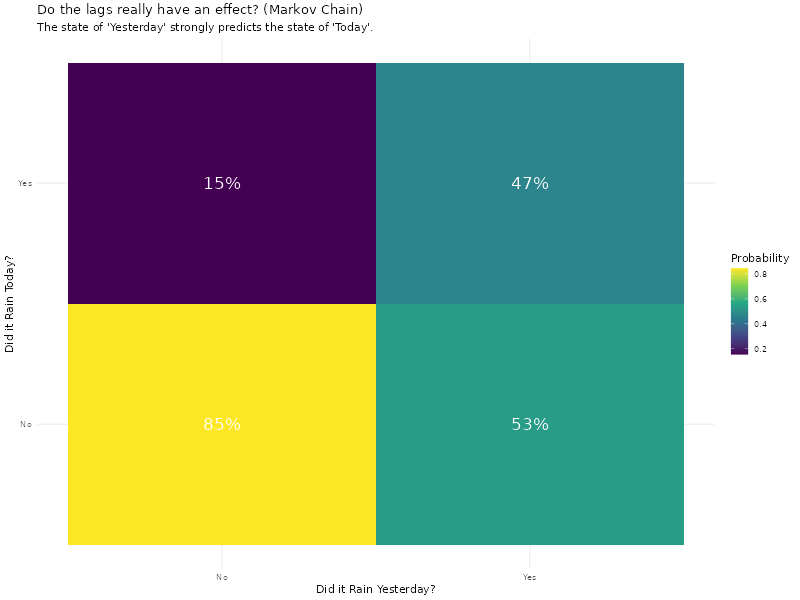

In [13]:
df_final %>%
  group_by(location) %>%
  arrange(date) %>%
  mutate(yesterday_rain = lag(rain_today)) %>%
  ungroup() %>%
  filter(!is.na(rain_today), !is.na(yesterday_rain)) %>%
  count(yesterday_rain, rain_today) %>%
  group_by(yesterday_rain) %>%
  mutate(prob = n / sum(n)) %>%
  ggplot(aes(x = yesterday_rain, y = rain_today, fill = prob)) +
  geom_tile() +
  geom_text(aes(label = scales::percent(prob, accuracy = 1)), color = "white", size = 6) +
  scale_fill_viridis_c() +
  labs(
    title = "Do the lags really have an effect? (Markov Chain)",
    subtitle = "The state of 'Yesterday' strongly predicts the state of 'Today'.",
    x = "Did it Rain Yesterday?",
    y = "Did it Rain Today?",
    fill = "Probability"
  ) +
  theme_minimal()

## 6.2 Interaction Effects: The Rain Corner

Warning message:
In geom_density2d_filled(continuous_var = "ndensity", bins = 7) :
  Ignoring unknown parameters: `continuous_var`


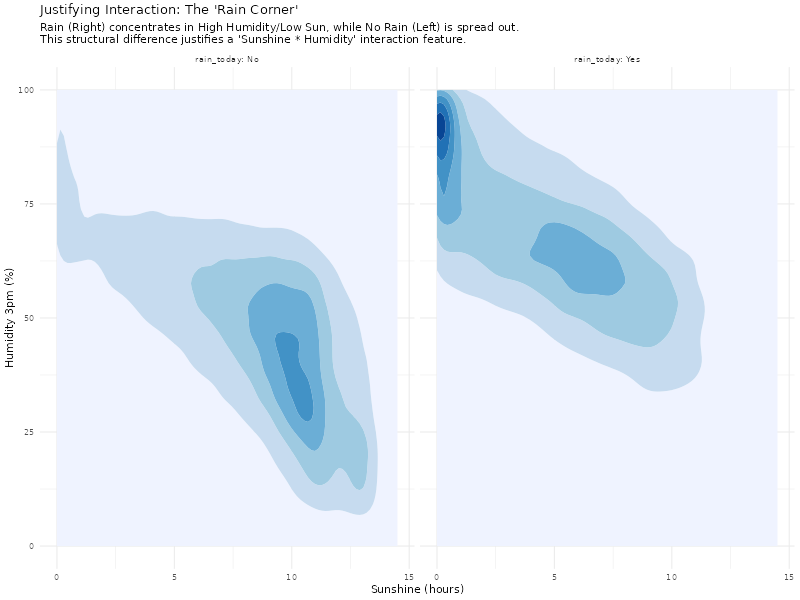

In [14]:
df_final %>% 
  group_by(location) %>% 
  arrange(date) %>% 
  mutate(
    rain_index_ref = ifelse(rainfall > 0, row_number(), NA_integer_)
  ) %>% 
  fill(rain_index_ref, .direction = "down") %>% 
  mutate(
    days_since_rain = row_number() - lag(rain_index_ref)
  ) %>% 
  select(-rain_index_ref) %>% 
  ggplot(aes(sunshine, humidity3pm)) +
  geom_density2d_filled(continuous_var = "ndensity", bins = 7) +
  facet_wrap(~rain_today, labeller = label_both) +
  scale_fill_brewer(palette = "Blues") +
  labs(
    title = "Justifying Interaction: The 'Rain Corner'",
    subtitle = "Rain (Right) concentrates in High Humidity/Low Sun, while No Rain (Left) is spread out.\nThis structural difference justifies a 'Sunshine * Humidity' interaction feature.",
    x = "Sunshine (hours)",
    y = "Humidity 3pm (%)"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

## 6.3 Dry Spell Analysis

Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once per session.
Call ]8;;x-r-run:lifecycle::last_lifecycle_warnings()lifecycle::last_lifecycle_warnings()]8;; to see where this warning was
generated. 


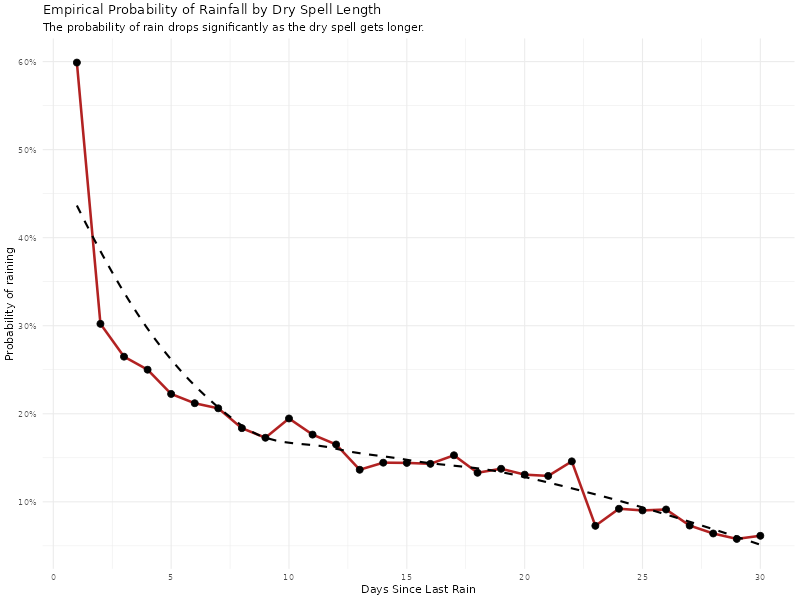

`geom_smooth()` using formula = 'y ~ x'

In [15]:
df_final %>% 
  group_by(location) %>% 
  arrange(date) %>% 
  mutate(
    did_rain_yesterday = lag(rainfall > 0, default = FALSE),
    dry_spell_id = cumsum(did_rain_yesterday)
  ) %>% 
  group_by(location, dry_spell_id) %>% 
  mutate(days_since_rain = row_number()) %>% 
  ungroup() %>% 
  filter(days_since_rain <= 30) %>%
  group_by(days_since_rain) %>%
  summarise(prob_rain = mean(rainfall > 0, na.rm = TRUE)) %>%
  ggplot(aes(x = days_since_rain, y = prob_rain)) +
  geom_line(color = "firebrick", size = 1.2) +
  geom_point(size = 3) +
  geom_smooth(method = "loess", se = FALSE, color = "black", linetype = "dashed") +
  scale_y_continuous(labels = scales::percent_format(1),
                    breaks = pretty_breaks(n = 6)) +
  scale_x_continuous(breaks = scales::pretty_breaks()) +
  labs(x = "Days Since Last Rain", 
       y = "Probability of raining", 
       subtitle = "The probability of rain drops significantly as the dry spell gets longer.",
       title = "Empirical Probability of Rainfall by Dry Spell Length") +
  theme_minimal()

## 6.4 Pressure Analysis

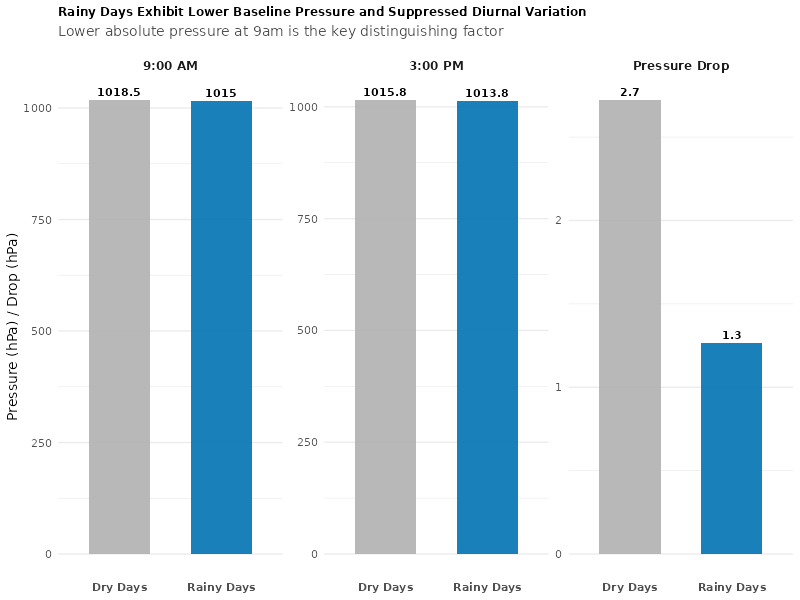

In [16]:
data_wide <- df_final %>% 
  group_by(rain_today) %>% 
  summarise(
    `9:00 AM` = mean(pressure9am, na.rm = TRUE),
    `3:00 PM` = mean(pressure3pm, na.rm = TRUE),
    `Pressure Drop` = mean(pressure9am, na.rm = TRUE) - mean(pressure3pm, na.rm = TRUE)
  ) %>% 
  pivot_longer(cols = -rain_today, names_to = "metric", values_to = "value") %>% 
  mutate(
    metric = factor(metric, levels = c("9:00 AM", "3:00 PM", "Pressure Drop")),
    label_txt = round(value, 1)
  )

ggplot(data_wide, aes(x = rain_today, y = value, fill = rain_today)) +
  geom_col(width = 0.6, alpha = 0.9) +
  geom_text(aes(label = label_txt), vjust = -0.5, fontface = "bold", size = 4) +
  facet_wrap(~metric, scales = "free_y", nrow = 1) +
  scale_fill_manual(values = c("No" = "#B0B0B0", "Yes" = "#0072B2")) +
  scale_x_discrete(labels = c("No" = "Dry Days", "Yes" = "Rainy Days")) +
  labs(
    title = "Rainy Days Exhibit Lower Baseline Pressure and Suppressed Diurnal Variation",
    subtitle = "Lower absolute pressure at 9am is the key distinguishing factor",
    y = "Pressure (hPa) / Drop (hPa)",
    x = NULL
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "none",
    plot.title = element_text(face = "bold", size = 12),
    plot.subtitle = element_text(color = "grey30", margin = margin(b = 15)),
    axis.text.x = element_text(face = "bold", size = 11),
    strip.text = element_text(face = "bold", size = 12),
    panel.grid.major.x = element_blank()
  )

In [17]:
df_final %>% 
  mutate(pressure_change = pressure3pm - pressure9am) %>% 
  rstatix::cohens_d(pressure_change ~ rain_today)

# A tibble: 1 × 7
  .y.             group1 group2 effsize     n1    n2 magnitude
* <chr>           <chr>  <chr>    <dbl>  <int> <int> <ord>    
1 pressure_change No     Yes     -0.716 110319 31880 moderate 

In [18]:
df_final %>% 
  filter(rainfall > 0) %>% 
  group_by(month) %>% 
  summarise(median_rain = median(rainfall),
            mean_rain = mean(rainfall),
            rain_days = n(),
          .groups = "drop") %>% 
  mutate(month_label = factor(month.abb[month], levels = rev(month.abb))) -> monthly_stats

df_final %>% 
  filter(rainfall > 0) %>% 
  mutate(
    month_label = factor(month.abb[month], levels = rev(month.abb)),
    log_rain = log(rainfall)
  ) %>% 
  left_join(monthly_stats, by = c("month", "month_label")) -> plot_data

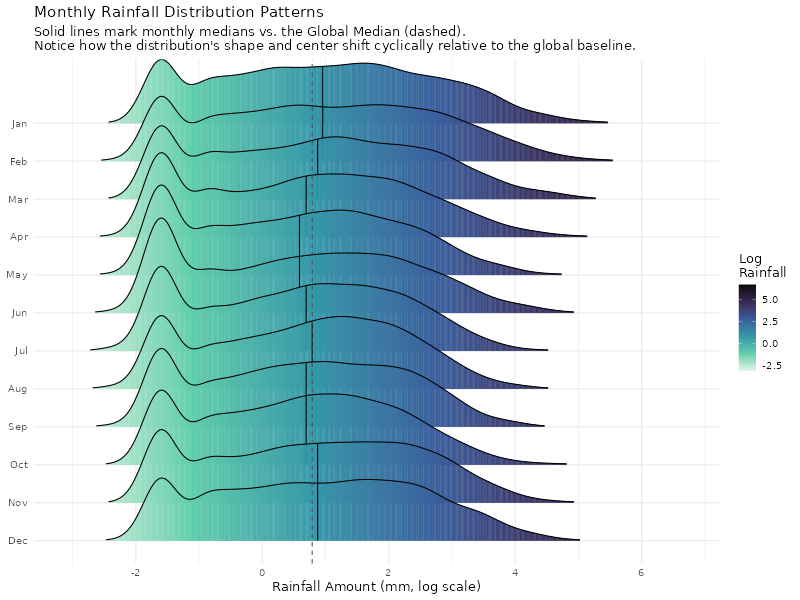

Picking joint bandwidth of 0.273

In [19]:
ggplot(plot_data, aes(log_rain, month_label, fill = after_stat(x))) +
  geom_density_ridges_gradient(    
    scale = 2.5, 
    rel_min_height = 0.01,
    quantile_lines = TRUE,
    quantiles = 2,
    alpha = 0.8
  ) +
  geom_vline(xintercept = median(log(df_final$rainfall[df_final$rainfall > 0])),
             linetype = "dashed", color = "grey30", linewidth = 0.5) +
  scale_fill_viridis_c(
    option = "mako", 
    name = "Log\nRainfall",
    direction = -1
  ) +
  scale_x_continuous(breaks = pretty_breaks()) +
  labs(
    title = "Monthly Rainfall Distribution Patterns",
    subtitle = "Solid lines mark monthly medians vs. the Global Median (dashed).\nNotice how the distribution's shape and center shift cyclically relative to the global baseline.",
    x = "Rainfall Amount (mm, log scale)",
    y = NULL
  ) +
  theme_minimal(base_size = 13)

In [20]:
plot_data_seasonal <- df_final %>% 
  filter(rainfall > 0) %>% 
  mutate(
    season = case_when(
      month %in% c(12, 1, 2) ~ "Summer",
      month %in% c(3, 4, 5) ~ "Autumn",
      month %in% c(6, 7, 8) ~ "Winter",
      month %in% c(9, 10, 11) ~ "Spring"
    ),
    season = factor(season, levels = c("Summer", "Autumn", "Winter", "Spring")),
    month_label = factor(month.abb[month], levels = month.abb)
  )

seasonal_data <- plot_data_seasonal %>% select(season, rainfall)

seasonal_data %>% 
  group_by(season) %>% 
  get_summary_stats(rainfall, type = "mean_sd")

# A tibble: 4 × 5
  season variable     n  mean    sd
  <fct>  <fct>    <dbl> <dbl> <dbl>
1 Summer rainfall 10571  9.07 18.2 
2 Autumn rainfall 13382  6.67 13.5 
3 Winter rainfall 15402  5.46  9.81
4 Spring rainfall 11764  5.65 10.5 

In [21]:
seasonal_data %>% kruskal_test(rainfall ~ season)
seasonal_data %>% kruskal_effsize(rainfall ~ season)

# A tibble: 1 × 5
  .y.          n effsize method  magnitude
* <chr>    <int>   <dbl> <chr>   <ord>    
1 rainfall 51119 0.00445 eta2[H] small    

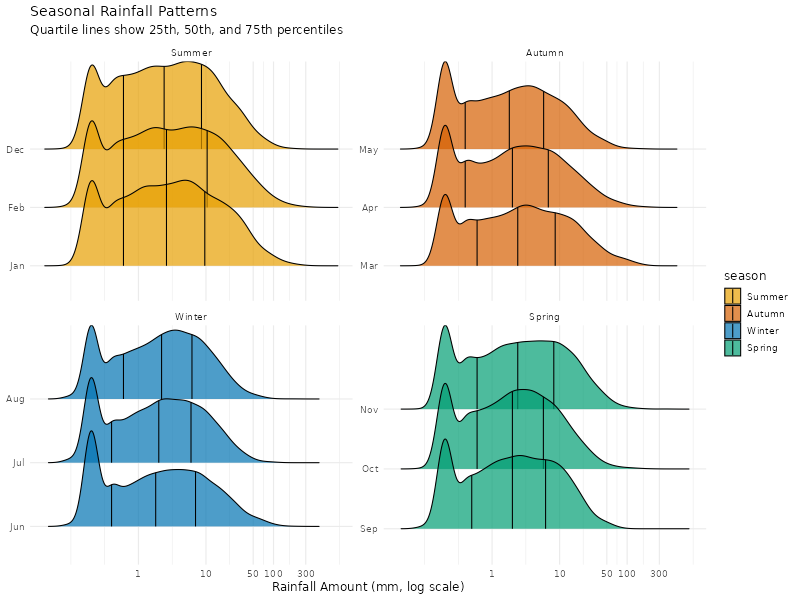

Picking joint bandwidth of 0.129
Picking joint bandwidth of 0.119
Picking joint bandwidth of 0.111
Picking joint bandwidth of 0.116

In [22]:
ggplot(plot_data_seasonal, aes(rainfall, month_label, fill = season)) +
  geom_density_ridges(
    scale = 1.5,
    alpha = 0.7,
    quantile_lines = TRUE,
    quantiles = c(0.25, 0.5, 0.75)
  ) +
  scale_x_log10(
    breaks = c(1, 10, 50, 100, 300),
    labels = label_number(accuracy = 1)
  ) +
  scale_fill_manual(
    values = c("Summer" = "#E69F00", "Autumn" = "#D55E00", 
               "Winter" = "#0072B2", "Spring" = "#009E73")
  ) +
  facet_wrap(~season, scales = "free_y", ncol = 2) +
  labs(
    title = "Seasonal Rainfall Patterns",
    subtitle = "Quartile lines show 25th, 50th, and 75th percentiles",
    x = "Rainfall Amount (mm, log scale)",
    y = NULL
  ) +
  theme_minimal(base_size = 12)

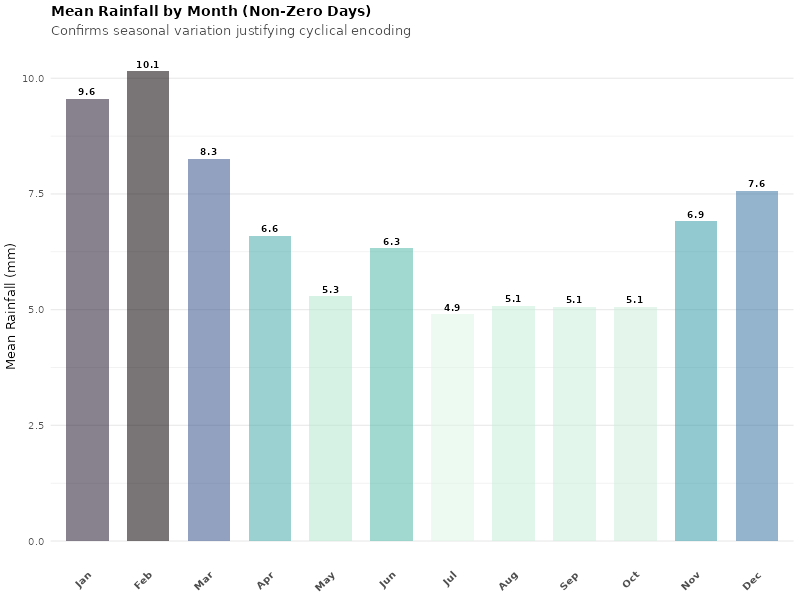

In [23]:
monthly_stats %>% 
  mutate(month_label = factor(month.abb[month], levels = month.abb)) %>% 
  ggplot(aes(month_label, mean_rain)) +
  geom_col(aes(fill = mean_rain, alpha = 0.8, width = 0.7)) +
  geom_text(aes(label = round(mean_rain, 1)), 
            vjust = -0.5, size = 3.5, fontface = "bold") +
  scale_fill_viridis_c(option = "mako", direction = -1) +
  labs(
    title = "Mean Rainfall by Month (Non-Zero Days)",
    subtitle = "Confirms seasonal variation justifying cyclical encoding",
    y = "Mean Rainfall (mm)",
    x = NULL
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", size = 14),
    plot.subtitle = element_text(color = "grey30", margin = margin(b = 10)),
    legend.position = "none",
    panel.grid.major.x = element_blank(),
    axis.text.x = element_text(angle = 45, hjust = 1, face = "bold")
  )

## 6.6 Moving Averages Analysis

In [24]:
ma_data <- df_final %>% 
  group_by(location) %>% 
  arrange(date) %>% 
  mutate(
    rainfall_ma3 = rollmean(rainfall, k = 3, fill = NA, align = "right"),
    rainfall_ma7 = rollmean(rainfall, k = 7, fill = NA, align = "right"),
    humidity_ma3 = rollmean(humidity3pm, k = 3, fill = NA, align = "right"),
    humidity_ma7 = rollmean(humidity3pm, k = 7, fill = NA, align = "right")
  ) %>% 
  ungroup()

Warning message:
The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
This warning is displayed once per session.
Call ]8;;x-r-run:lifecycle::last_lifecycle_warnings()lifecycle::last_lifecycle_warnings()]8;; to see where this warning was
generated. 


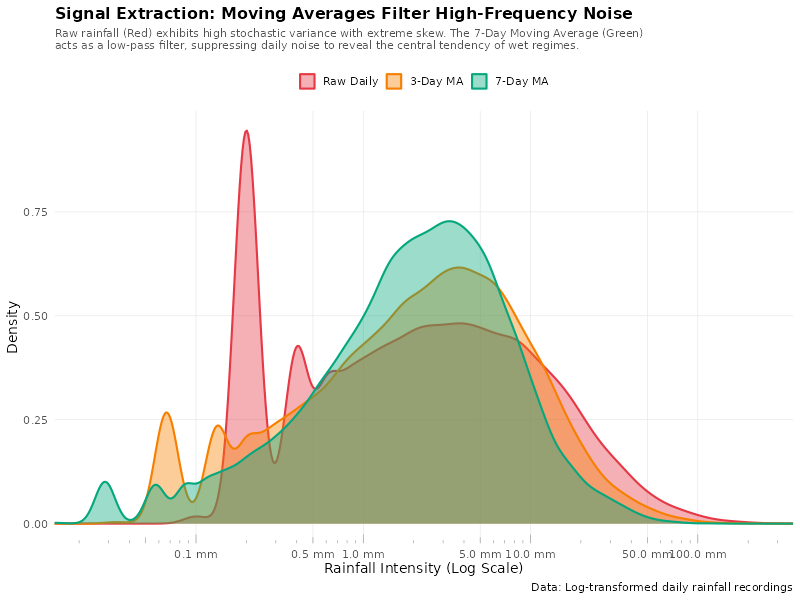

In [25]:
p1_data <- ma_data %>% 
  filter(rainfall > 0) %>% 
  select(rainfall, rainfall_ma3, rainfall_ma7) %>% 
  pivot_longer(everything(), names_to = "metric", values_to = "value") %>% 
  filter(!is.na(value)) %>% 
  mutate(
    metric = factor(metric, 
                    levels = c("rainfall", "rainfall_ma3", "rainfall_ma7"),
                    labels = c("Raw Daily", "3-Day MA", "7-Day MA"))
  )

ggplot(p1_data, aes(x = value, fill = metric, color = metric)) +
  geom_density(alpha = 0.4, linewidth = 1) +
  annotation_logticks(sides = "b", color = "grey60", linewidth = 0.3) + 
  scale_x_log10(
    breaks = c(0.1, 0.5, 1, 5, 10, 50, 100), 
    labels = label_number(suffix = " mm"),
    expand = c(0, 0)
  ) +
  scale_fill_manual(
    values = c("Raw Daily" = "#E63946", "3-Day MA" = "#F77F00", "7-Day MA" = "#06A77D")
  ) +
  scale_color_manual(
    values = c("Raw Daily" = "#E63946", "3-Day MA" = "#F77F00", "7-Day MA" = "#06A77D")
  ) +
  labs(
    title = "Signal Extraction: Moving Averages Filter High-Frequency Noise",
    subtitle = "Raw rainfall (Red) exhibits high stochastic variance with extreme skew. The 7-Day Moving Average (Green)\nacts as a low-pass filter, suppressing daily noise to reveal the central tendency of wet regimes.",
    x = "Rainfall Intensity (Log Scale)",
    y = "Density",
    caption = "Data: Log-transformed daily rainfall recordings",
    fill = NULL,
    color = NULL
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "top",
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_line(color = "grey90", size = 0.3),
    panel.grid.major.y = element_line(color = "grey90", size = 0.3),
    plot.title = element_text(face = "bold", size = 16),
    plot.subtitle = element_text(color = "grey30", size = 11, margin = margin(b = 15)),
    axis.text.x = element_text(margin = margin(t = 5))
  )

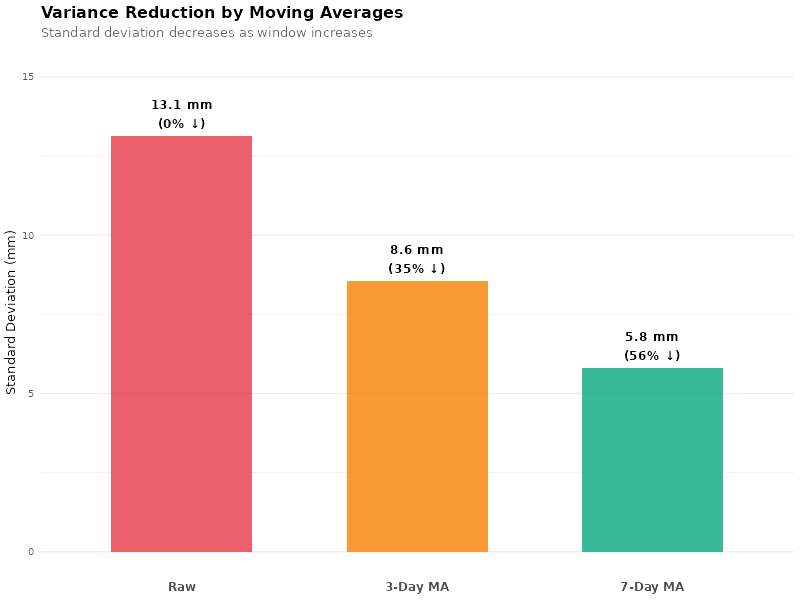

In [26]:
variance_data <- ma_data %>% 
  filter(rainfall > 0) %>% 
  summarise(
    Raw = sd(rainfall, na.rm = TRUE),
    `3-Day MA` = sd(rainfall_ma3, na.rm = TRUE),
    `7-Day MA` = sd(rainfall_ma7, na.rm = TRUE)
  ) %>% 
  pivot_longer(everything(), names_to = "metric", values_to = "sd") %>% 
  mutate(
    metric = factor(metric, levels = c("Raw", "3-Day MA", "7-Day MA")),
    variance_reduction = (sd[1] - sd) / sd[1] * 100
  )

ggplot(variance_data, aes(metric, sd, fill = metric)) +
  geom_col(alpha = 0.8, width = 0.6) +
  geom_text(aes(label = sprintf("%.1f mm\n(%.0f%% ↓)", sd, variance_reduction)),
            vjust = -0.3, fontface = "bold", size = 4.5) +
  scale_fill_manual(
    values = c("Raw" = "#E63946", "3-Day MA" = "#F77F00", "7-Day MA" = "#06A77D")
  ) +
  labs(
    title = "Variance Reduction by Moving Averages",
    subtitle = "Standard deviation decreases as window increases",
    y = "Standard Deviation (mm)",
    x = NULL
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", size = 16),
    plot.subtitle = element_text(color = "grey40", margin = margin(b = 10)),
    legend.position = "none",
    panel.grid.major.x = element_blank(),
    axis.text.x = element_text(face = "bold", size = 12)
  ) +
  ylim(0, max(variance_data$sd) * 1.15)

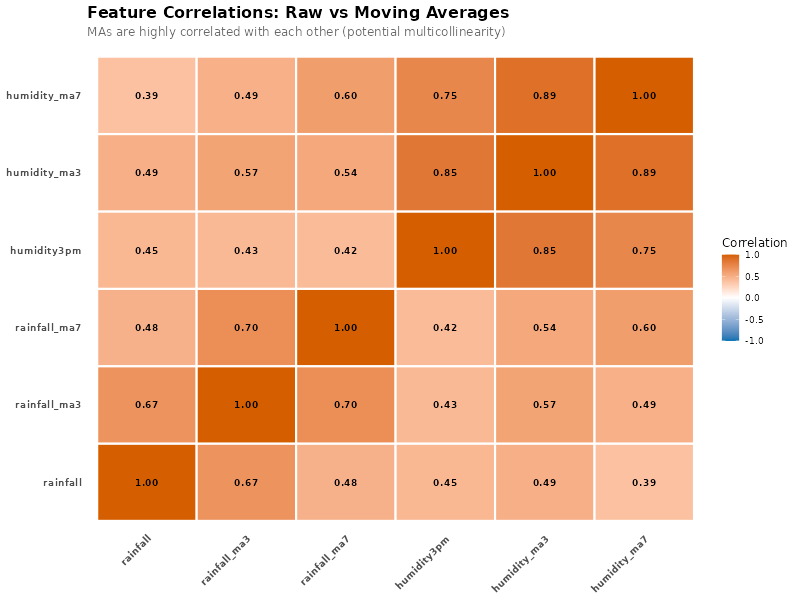

In [27]:
cor_data <- ma_data %>% 
  select(rainfall, rainfall_ma3, rainfall_ma7, humidity3pm, humidity_ma3, humidity_ma7) %>% 
  cor(use = "complete.obs", method = "spearman") %>% 
  as.data.frame() %>% 
  rownames_to_column("var1") %>% 
  pivot_longer(-var1, names_to = "var2", values_to = "correlation") %>% 
  mutate(
    var1 = factor(var1, levels = c("rainfall", "rainfall_ma3", "rainfall_ma7",
                                    "humidity3pm", "humidity_ma3", "humidity_ma7")),
    var2 = factor(var2, levels = c("rainfall", "rainfall_ma3", "rainfall_ma7",
                                    "humidity3pm", "humidity_ma3", "humidity_ma7"))
  )  

ggplot(cor_data, aes(var2, var1, fill = correlation)) +
  geom_tile(color = "white", linewidth = 1) +
  geom_text(aes(label = sprintf("%.2f", correlation)),
            fontface = "bold", size = 3.5) +
  scale_fill_gradient2(
    low = "#0072B2", mid = "white", high = "#D55E00",
    midpoint = 0, limits = c(-1, 1), name = "Correlation"
  ) +
  labs(
    title = "Feature Correlations: Raw vs Moving Averages",
    subtitle = "MAs are highly correlated with each other (potential multicollinearity)",
    x = NULL, y = NULL
  ) +
  theme_minimal(base_size = 12) +
  theme(
    plot.title = element_text(face = "bold", size = 16),
    plot.subtitle = element_text(color = "grey40", margin = margin(b = 10)),
    axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"),
    axis.text.y = element_text(face = "bold"),
    panel.grid = element_blank()
  )

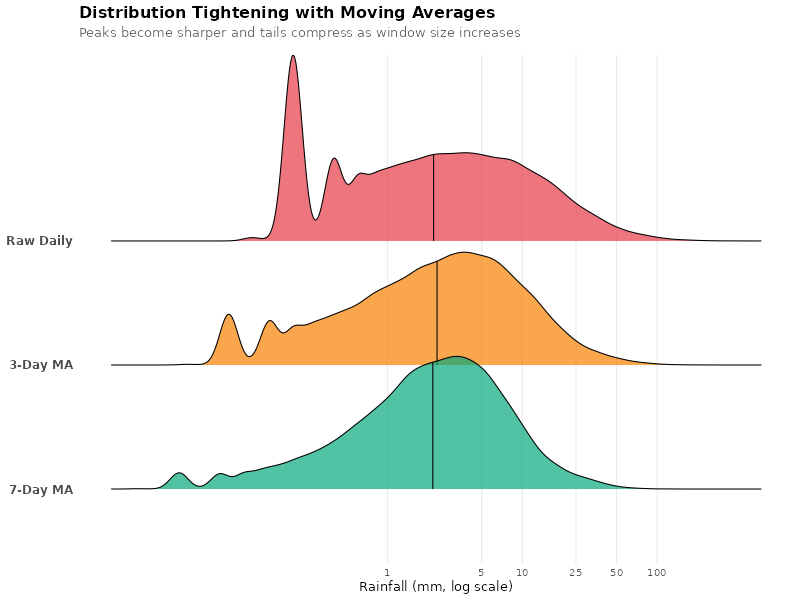

Picking joint bandwidth of 0.0669

In [28]:
ridge_data <- ma_data %>% 
  filter(rainfall > 0) %>% 
  select(rainfall, rainfall_ma3, rainfall_ma7) %>% 
  pivot_longer(everything(), names_to = "metric", values_to = "value") %>% 
  filter(!is.na(value)) %>% 
  mutate(
    metric = factor(metric,
                    levels = c("rainfall_ma7", "rainfall_ma3", "rainfall"),
                    labels = c("7-Day MA", "3-Day MA", "Raw Daily"))
  )

ggplot(ridge_data, aes(value, metric, fill = metric)) +
  geom_density_ridges(
    alpha = 0.7,
    scale = 1.5,
    quantile_lines = TRUE,
    quantiles = 2
  ) +
  scale_x_log10(breaks = c(1, 5, 10, 25, 50, 100),
    labels = c("1", "5", "10", "25", "50", "100")) +
  scale_fill_manual(values = c("Raw Daily" = "#E63946", 
               "3-Day MA" = "#F77F00", 
               "7-Day MA" = "#06A77D")) +
  labs(
    title = "Distribution Tightening with Moving Averages",
    subtitle = "Peaks become sharper and tails compress as window size increases",
    x = "Rainfall (mm, log scale)",
    y = NULL
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", size = 16),
    plot.subtitle = element_text(color = "grey40", margin = margin(b = 15)),
    legend.position = "none",
    axis.text.y = element_text(face = "bold", size = 12),
    panel.grid.minor = element_blank(),
    panel.grid.major.y = element_blank()
  )

# 7. Feature Engineering

In [29]:
compass_lookup <- c(
  "N"=0, "NNE"=22.5, "NE"=45, "ENE"=67.5,
  "E"=90, "ESE"=112.5, "SE"=135, "SSE"=157.5,
  "S"=180, "SSW"=202.5, "SW"=225, "WSW"=247.5,
  "W"=270, "WNW"=292.5, "NW"=315, "NNW"=337.5
)

In [30]:
df_final <- df_final %>% 
  group_by(location) %>% 
  arrange(date) %>% 
  mutate(
    rainfall_ma7 = lag(rollmean(rainfall, k = 7, fill = NA, align = "right"), n = 1),
    humidity_ma7 = lag(rollmean(humidity3pm, k = 7, fill = NA, align = "right"), 1),
    rain_event_id = cumsum(lag(rainfall, 1) > 0),
    days_since_rain = row_number() - match(rain_event_id, rain_event_id),
    rain_yesterday = lag(rain_today, n = 1)
  ) %>% 
  ungroup() %>% 
  filter(!is.na(rain_yesterday), !is.na(rainfall_ma7)) %>% 
  select(-rain_event_id) %>% 
  mutate(
    day_of_year = yday(date),
    sunshine = scale(sunshine, center = TRUE, scale = FALSE),
    humidity3pm = scale(humidity3pm, center = TRUE, scale = FALSE),
    pressure_change = pressure3pm - pressure9am,
    sun_humid_interaction = as.numeric(sunshine * humidity3pm),
    dewpoint_9am = temp9am - ((100 - humidity9am) / 5),
    dewpoint_3pm = temp3pm - ((100 - humidity3pm) / 5),
    dewpoint_change = dewpoint_3pm - dewpoint_9am,
    moisture_index = humidity3pm * (1 - sunshine / 15),
    instability_index = (1020 - pressure3pm) * humidity3pm / 100,
    cloud_development = pmax(0, cloud3pm - cloud9am),
    day_sin = sin(2 * pi * day_of_year / 365),
    day_cos = cos(2 * pi * day_of_year / 365),
    gust_rad = compass_lookup[wind_gust_dir] * pi / 180,
    gust_V_NS = wind_gust_speed * cos(gust_rad),
    gust_U_EW = wind_gust_speed * sin(gust_rad),
    wind9am_rad = compass_lookup[wind_dir9am] * pi / 180,
    wind9am_V_NS = wind_speed9am * cos(wind9am_rad),
    wind9am_U_EW = wind_speed9am * sin(wind9am_rad)
  ) %>% 
  relocate(rain_today, date, location) %>% 
  relocate(rain_yesterday, days_since_rain, .after = location) %>%
  relocate(ends_with("_ma7"), .after = days_since_rain) %>% 
  relocate(day_sin, day_cos, .after = date)

# 8. Multicollinearity Check

In [31]:
df_wo_location <- select_model_features(df_final, keep_location = FALSE)
mc_check(df_wo_location)

# Check for Multicollinearity

Low Correlation

                  Term  VIF   VIF 95% CI adj. VIF Tolerance Tolerance 95% CI
               day_sin 1.19 [1.19, 1.20]     1.09      0.84     [0.83, 0.84]
               day_cos 1.94 [1.93, 1.96]     1.39      0.52     [0.51, 0.52]
        rain_yesterday 1.19 [1.18, 1.20]     1.09      0.84     [0.84, 0.85]
       days_since_rain 1.00 [1.00, 1.02]     1.00      1.00     [0.98, 1.00]
          rainfall_ma7 1.34 [1.33, 1.35]     1.16      0.75     [0.74, 0.75]
          humidity_ma7 2.39 [2.38, 2.41]     1.55      0.42     [0.41, 0.42]
           evaporation 1.74 [1.72, 1.75]     1.32      0.58     [0.57, 0.58]
              sunshine 2.11 [2.10, 2.13]     1.45      0.47     [0.47, 0.48]
           humidity9am 2.90 [2.87, 2.92]     1.70      0.35     [0.34, 0.35]
       pressure_change 1.69 [1.68, 1.71]     1.30      0.59     [0.59, 0.59]
 sun_humid_interaction 1.25 [1.24, 1.26]     1.12      0.80     [0.79, 0.80]
          dewpoint_9am 2.29 

In [ ]:
model_matrix <- model.matrix(rainfall ~ ., data = df_wo_location)
linear_combos <- findLinearCombos(model_matrix)
print(linear_combos)

$linearCombos
list()

$remove
NULL

[1] "gust_V_NS"             "sun_humid_interaction" "dewpoint_change"      
[1] "gust_V_NS"


In [33]:
df_scaled <- df_wo_location %>% scale_data()

# 9. Model Building

## 9.1 Progressive Model Development

In [34]:
m0_null <- glmmTMB(
  rainfall ~ 1, 
  ziformula = ~ 1, 
  data = df_scaled, 
  family = ziGamma(link = "log")
)

summary(m0_null)

 Family: Gamma  ( log )
Formula:          rainfall ~ 1
Zero inflation:            ~1
Data: df_scaled

      AIC       BIC    logLik -2*log(L)  df.resid 
 461669.7  461699.3 -230831.8  461663.7    141853 


Dispersion estimate for Gamma family (sigma^2): 1.88 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 1.882520   0.006072     310   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 0.576891   0.005533   104.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [35]:
m1_moisture <- update(
  m0_null, 
  . ~ . + humidity3pm + dewpoint_9am + dewpoint_change + pressure_change, 
  ziformula = ~ humidity3pm + dewpoint_9am
)
summary(m1_moisture)

 Family: Gamma  ( log )
Formula:          
rainfall ~ humidity3pm + dewpoint_9am + dewpoint_change + pressure_change
Zero inflation:            ~humidity3pm + dewpoint_9am
Data: df_scaled

      AIC       BIC    logLik -2*log(L)  df.resid 
 422846.6  422935.4 -211414.3  422828.6    141847 


Dispersion estimate for Gamma family (sigma^2): 1.63 

Conditional model:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      1.297705   0.007670  169.19   <2e-16 ***
humidity3pm      0.379367   0.006585   57.61   <2e-16 ***
dewpoint_9am     0.383793   0.005768   66.54   <2e-16 ***
dewpoint_change -0.103967   0.006915  -15.03   <2e-16 ***
pressure_change  0.230394   0.005203   44.28   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.7143554  0.0063567  112.38   <2e-16 ***
humidity3pm  -1.0688804  0.0074142 -144.17   <2e-16 ***
dewpoint_9am  0.0007181  0.

In [36]:
m2_temporal <- update(
  m1_moisture, 
  . ~ . + day_cos + day_sin,
  ziformula = ~ humidity3pm + dewpoint_9am + rain_yesterday + cloud_development + pressure_change
)
summary(m2_temporal)

 Family: Gamma  ( log )
Formula:          
rainfall ~ humidity3pm + dewpoint_9am + dewpoint_change + pressure_change +  
    day_cos + day_sin
Zero inflation:            
~humidity3pm + dewpoint_9am + rain_yesterday + cloud_development + 
    pressure_change
Data: df_scaled

      AIC       BIC    logLik -2*log(L)  df.resid 
 406659.3  406797.3 -203315.6  406631.3    141842 


Dispersion estimate for Gamma family (sigma^2): 1.63 

Conditional model:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      1.289586   0.007727  166.89  < 2e-16 ***
humidity3pm      0.393871   0.007150   55.09  < 2e-16 ***
dewpoint_9am     0.379929   0.008015   47.41  < 2e-16 ***
dewpoint_change -0.111155   0.007531  -14.76  < 2e-16 ***
pressure_change  0.227524   0.005421   41.97  < 2e-16 ***
day_cos          0.030193   0.007517    4.02 5.91e-05 ***
day_sin         -0.044115   0.006345   -6.95 3.58e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation

In [37]:
m3_history <- update(
  m2_temporal, 
  . ~ . + rainfall_ma7 + days_since_rain + humidity_ma7 + rain_yesterday,
  ziformula = ~ humidity3pm + dewpoint_9am + rain_yesterday + cloud_development + pressure_change
)
summary(m3_history)

 Family: Gamma  ( log )
Formula:          
rainfall ~ humidity3pm + dewpoint_9am + dewpoint_change + pressure_change +  
    day_cos + day_sin + rainfall_ma7 + days_since_rain + humidity_ma7 +  
    rain_yesterday
Zero inflation:            
~humidity3pm + dewpoint_9am + rain_yesterday + cloud_development + 
    pressure_change
Data: df_scaled

      AIC       BIC    logLik -2*log(L)  df.resid 
 404936.2  405113.7 -202450.1  404900.2    141838 


Dispersion estimate for Gamma family (sigma^2): 1.59 

Conditional model:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        1.141419   0.008764  130.24  < 2e-16 ***
humidity3pm        0.391649   0.007700   50.86  < 2e-16 ***
dewpoint_9am       0.337344   0.008098   41.66  < 2e-16 ***
dewpoint_change   -0.127573   0.007419  -17.20  < 2e-16 ***
pressure_change    0.221880   0.005361   41.39  < 2e-16 ***
day_cos            0.022462   0.007544    2.98  0.00291 ** 
day_sin           -0.051704   0.006228   -8.30  < 2e-16

In [38]:
m4_energy <- update(
  m3_history, 
  . ~ . + sunshine + evaporation + instability_index + sun_humid_interaction + cloud_development,
  ziformula = ~ humidity3pm + dewpoint_9am + rain_yesterday + cloud_development + pressure_change
)
summary(m4_energy)

 Family: Gamma  ( log )
Formula:          
rainfall ~ humidity3pm + dewpoint_9am + dewpoint_change + pressure_change +  
    day_cos + day_sin + rainfall_ma7 + days_since_rain + humidity_ma7 +  
    rain_yesterday + sunshine + evaporation + instability_index +  
    sun_humid_interaction + cloud_development
Zero inflation:            
~humidity3pm + dewpoint_9am + rain_yesterday + cloud_development + 
    pressure_change
Data: df_scaled

      AIC       BIC    logLik -2*log(L)  df.resid 
 403051.8  403278.7 -201502.9  403005.8    141833 


Dispersion estimate for Gamma family (sigma^2): 1.55 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            1.183099   0.009162  129.12  < 2e-16 ***
humidity3pm            0.080854   0.012745    6.34 2.24e-10 ***
dewpoint_9am           0.348377   0.008521   40.89  < 2e-16 ***
dewpoint_change       -0.104801   0.007847  -13.36  < 2e-16 ***
pressure_change        0.260113   0.005670   45.87  < 2e-16 

In [39]:
m5_wind <- update(
  m4_energy, 
  . ~ . + gust_U_EW + gust_V_NS + wind9am_V_NS + wind9am_U_EW,
  ziformula = ~ humidity3pm + dewpoint_9am + rain_yesterday + cloud_development + pressure_change
)
summary(m5_wind)

 Family: Gamma  ( log )
Formula:          
rainfall ~ humidity3pm + dewpoint_9am + dewpoint_change + pressure_change +  
    day_cos + day_sin + rainfall_ma7 + days_since_rain + humidity_ma7 +  
    rain_yesterday + sunshine + evaporation + instability_index +  
    sun_humid_interaction + cloud_development + gust_U_EW + gust_V_NS +  
    wind9am_V_NS + wind9am_U_EW
Zero inflation:            
~humidity3pm + dewpoint_9am + rain_yesterday + cloud_development + 
    pressure_change
Data: df_scaled

      AIC       BIC    logLik -2*log(L)  df.resid 
 402452.7  402719.0 -201199.3  402398.7    141829 


Dispersion estimate for Gamma family (sigma^2): 1.53 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            1.155021   0.009206  125.46  < 2e-16 ***
humidity3pm            0.066044   0.012802    5.16 2.48e-07 ***
dewpoint_9am           0.379065   0.008646   43.84  < 2e-16 ***
dewpoint_change       -0.101583   0.007815  -13.00  < 2e-16 ***


## 9.2 Mixed Effects Model

In [40]:
# random_effects data 
re_data <- select_model_features(df_final, keep_location = TRUE) %>% 
          scale_data()

In [41]:
m6_mixed <- glmmTMB(
  rainfall ~ 
    humidity3pm + dewpoint_9am + dewpoint_change + pressure_change +
    day_cos + day_sin + rainfall_ma7 + days_since_rain + humidity_ma7 + rain_yesterday +
    sunshine + evaporation + instability_index + sun_humid_interaction + cloud_development +
    gust_U_EW + gust_V_NS + wind9am_V_NS + wind9am_U_EW +
    (1 | location),
  ziformula = ~ 
    humidity3pm + dewpoint_9am + rain_yesterday + 
    cloud_development + pressure_change,  
  data = re_data,
  family = ziGamma(link = "log")
)

summary(m6_mixed)

 Family: Gamma  ( log )
Formula:          
rainfall ~ humidity3pm + dewpoint_9am + dewpoint_change + pressure_change +  
    day_cos + day_sin + rainfall_ma7 + days_since_rain + humidity_ma7 +  
    rain_yesterday + sunshine + evaporation + instability_index +  
    sun_humid_interaction + cloud_development + gust_U_EW + gust_V_NS +  
    wind9am_V_NS + wind9am_U_EW + (1 | location)
Zero inflation:            
~humidity3pm + dewpoint_9am + rain_yesterday + cloud_development + 
    pressure_change
Data: re_data

      AIC       BIC    logLik -2*log(L)  df.resid 
 400296.7  400572.8 -200120.3  400240.7    141828 

Random effects:

Conditional model:
 Groups   Name        Variance Std.Dev.
 location (Intercept) 0.09024  0.3004  
Number of obs: 141856, groups:  location, 49

Dispersion estimate for Gamma family (sigma^2): 1.48 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            1.103933   0.043884   25.16  < 2e-16 ***
humidity3pm     

## 9.3 Random Effects Visualization

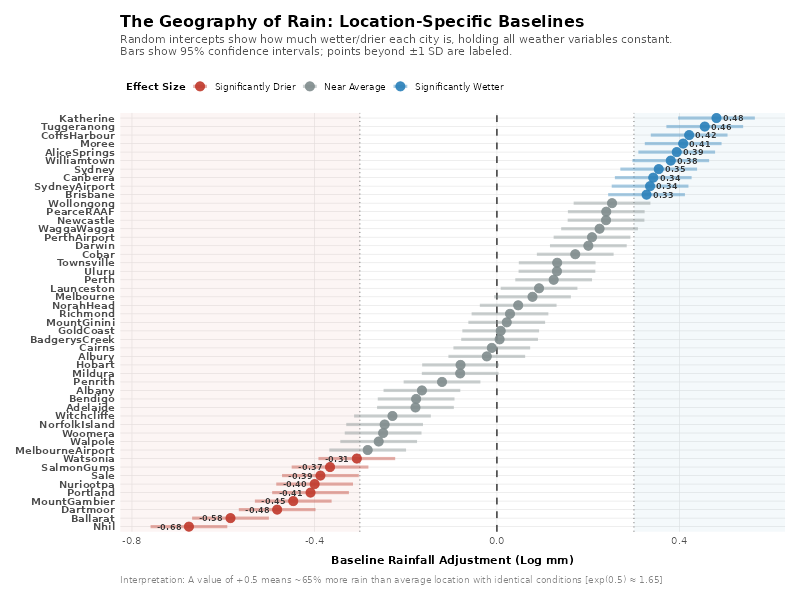

In [42]:
ranef_data <- ranef(m6_mixed)

loc_effects <- as.data.frame(ranef_data$cond$location) %>%
  rownames_to_column("Location") %>%
  rename(Effect = `(Intercept)`) %>%
  arrange(Effect) %>%
  mutate(
    Location = factor(Location, levels = Location),
    CI_lower = Effect - 1.96 * sd(Effect) / sqrt(n()),
    CI_upper = Effect + 1.96 * sd(Effect) / sqrt(n()),
    Category = case_when(
      Effect > sd(Effect) ~ "Significantly Wetter",
      Effect < -sd(Effect) ~ "Significantly Drier",
      TRUE ~ "Near Average"
    ),
    Category = factor(Category, levels = c("Significantly Drier", "Near Average", "Significantly Wetter"))
  )

ggplot(loc_effects, aes(x = Effect, y = Location)) +
  annotate("rect", 
           xmin = -Inf, xmax = -sd(loc_effects$Effect), 
           ymin = -Inf, ymax = Inf,
           fill = "#c0392b", alpha = 0.05) +
  annotate("rect", 
           xmin = sd(loc_effects$Effect), xmax = Inf, 
           ymin = -Inf, ymax = Inf,
           fill = "#2980b9", alpha = 0.05) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "grey30", linewidth = 0.8) +
  geom_vline(xintercept = c(-sd(loc_effects$Effect), sd(loc_effects$Effect)), 
             linetype = "dotted", color = "grey50", linewidth = 0.5) +
  geom_segment(aes(x = CI_lower, xend = CI_upper, 
                   y = Location, yend = Location,
                   color = Category),
               linewidth = 1.5, alpha = 0.4) +
  geom_point(aes(color = Category), size = 4, alpha = 0.9) +
  geom_text(
    data = filter(loc_effects, abs(Effect) > sd(Effect)),
    aes(label = sprintf("%.2f", Effect),
        x = Effect,
        hjust = ifelse(Effect > 0, -0.3, 1.3)),
    size = 3,
    fontface = "bold",
    color = "grey20"
  ) +
  scale_color_manual(
    values = c(
      "Significantly Drier" = "#c0392b",
      "Near Average" = "#7f8c8d",
      "Significantly Wetter" = "#2980b9"
    ),
    name = "Effect Size"
  ) +
  labs(
    title = "The Geography of Rain: Location-Specific Baselines",
    subtitle = "Random intercepts show how much wetter/drier each city is, holding all weather variables constant.\nBars show 95% confidence intervals; points beyond ±1 SD are labeled.",
    x = "Baseline Rainfall Adjustment (Log mm)",
    y = NULL,
    caption = "Interpretation: A value of +0.5 means ~65% more rain than average location with identical conditions [exp(0.5) ≈ 1.65]"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    panel.grid.major.y = element_line(color = "grey90", linewidth = 0.3),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_line(color = "grey90", linewidth = 0.3),
    plot.title = element_text(face = "bold", size = 16, margin = margin(b = 5)),
    plot.subtitle = element_text(color = "grey30", size = 11, margin = margin(b = 15)),
    plot.caption = element_text(color = "grey50", size = 9, hjust = 0, margin = margin(t = 10)),
    axis.text.y = element_text(size = 10, face = "bold"),
    axis.text.x = element_text(size = 10),
    axis.title.x = element_text(size = 11, face = "bold", margin = margin(t = 10)),
    legend.position = "top",
    legend.justification = "left",
    legend.title = element_text(face = "bold", size = 10),
    legend.text = element_text(size = 9),
    plot.margin = margin(15, 15, 15, 15)
  )

# 10. Model Diagnostics

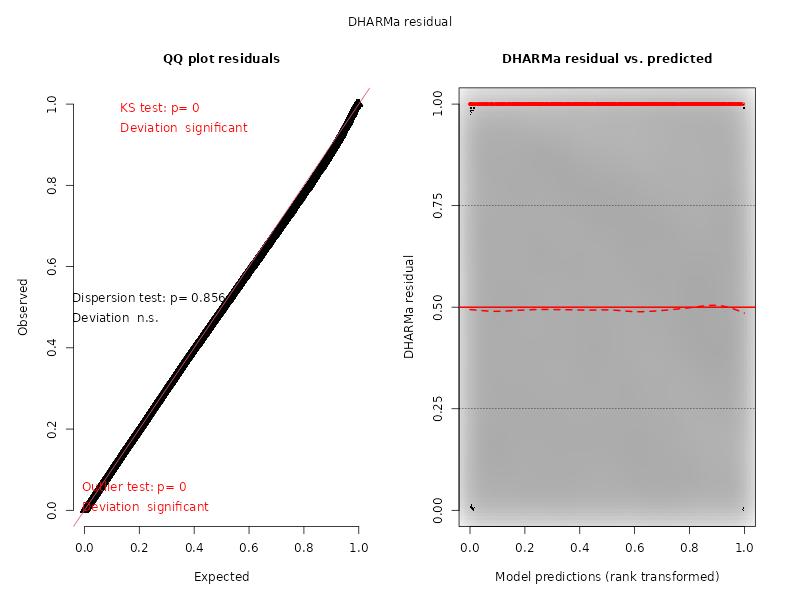

In [43]:
res <- simulateResiduals(m6_mixed)
plot(res)

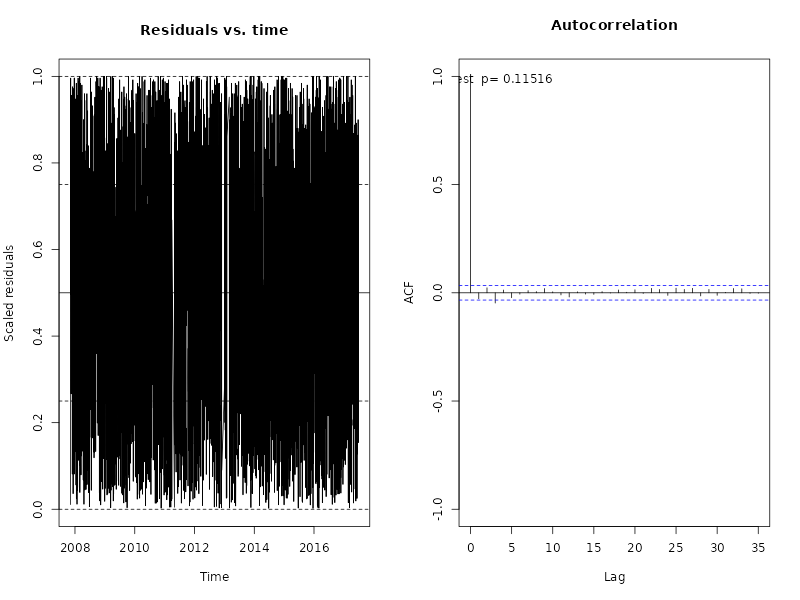


	Durbin-Watson test

data:  simulationOutput$scaledResiduals ~ 1
DW = 2.0539, p-value = 0.1152
alternative hypothesis: true autocorrelation is not 0



In [44]:
rows_used <- as.numeric(rownames(m6_mixed$frame))
Canberra_data <- df_final[rows_used, ] %>% 
  mutate(dharma_resid = residuals(res)) %>% 
  filter(location == "Canberra") %>% 
  arrange(date)

dw_result <- testTemporalAutocorrelation(
  simulationOutput = Canberra_data$dharma_resid, 
  time = Canberra_data$date
)
print(dw_result)

In [45]:
df_final$pred_rainfall <- predict(m6_mixed, type = "response")
global_rmse <- sqrt(mean((df_final$rainfall - df_final$pred_rainfall)^2))
global_mae <- mean(abs(df_final$rainfall - df_final$pred_rainfall))

print(paste("Global RMSE:", round(global_rmse, 3), "mm"))
print(paste("Global MAE:", round(global_mae, 3), "mm"))

[1] "Global RMSE: 7.563 mm"
[1] "Global MAE: 2.765 mm"


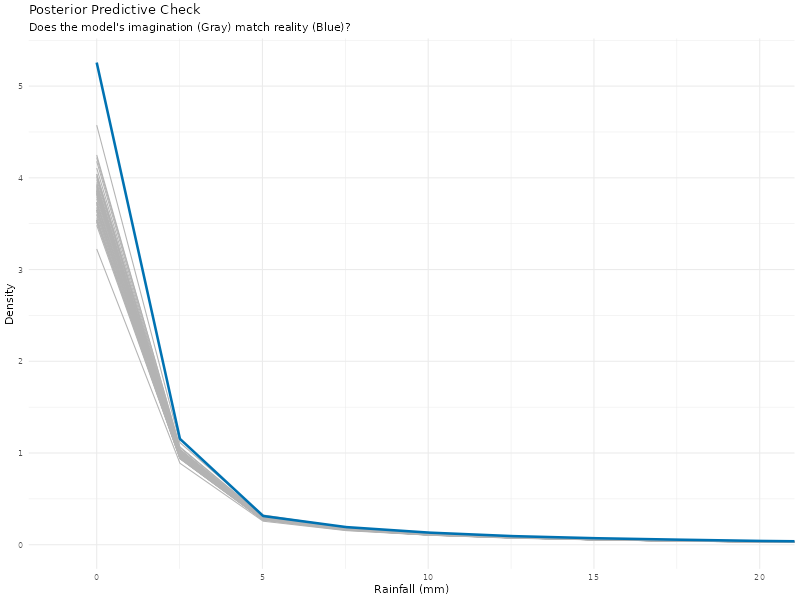

In [46]:
set.seed(123)
sims <- simulate(m6_mixed, nsim = 1000)
subset_sims <- sims[, sample(ncol(sims), 50)]

ppc_data <- bind_cols(
  Observed = df_scaled$rainfall,
  subset_sims
) %>%
  pivot_longer(cols = -Observed, names_to = "Simulation", values_to = "Simulated_Value")

ggplot() +
  geom_density(data = ppc_data, aes(x = Simulated_Value, group = Simulation), 
               color = "gray70", size = 0.5, alpha = 0.5) +
  geom_density(data = df_scaled, aes(x = rainfall), 
               color = "#0072B2", size = 1.2) +
  coord_cartesian(xlim = c(-1, 20)) + 
  labs(
    title = "Posterior Predictive Check",
    subtitle = "Does the model's imagination (Gray) match reality (Blue)?",
    x = "Rainfall (mm)",
    y = "Density"
  ) +
  theme_minimal()

# 11. Model Comparison

In [47]:
AIC(m0_null, m1_moisture, m2_temporal, m3_history, m4_energy, m5_wind, m6_mixed)

            df      AIC
m0_null      3 461669.7
m1_moisture  9 422846.6
m2_temporal 14 406659.3
m3_history  18 404936.2
m4_energy   23 403051.8
m5_wind     27 402452.7
m6_mixed    28 400296.7

## 11.1 Alternative Models

In [48]:
m_linear <- glmmTMB(
  rainfall ~ humidity3pm + dewpoint_9am + dewpoint_change + pressure_change +
    day_cos + day_sin + rainfall_ma7 + days_since_rain + humidity_ma7 +
    rain_yesterday + sunshine + evaporation + instability_index +
    sun_humid_interaction + cloud_development + gust_U_EW + gust_V_NS +
    wind9am_V_NS + wind9am_U_EW + (1 | location),
  data = re_data,
  family = gaussian(link = "identity")
)

m_tweedie <- glmmTMB(
  rainfall ~ humidity3pm + dewpoint_9am + dewpoint_change + pressure_change +
    day_cos + day_sin + rainfall_ma7 + days_since_rain + humidity_ma7 +
    rain_yesterday + sunshine + evaporation + instability_index +
    sun_humid_interaction + cloud_development + gust_U_EW + gust_V_NS +
    wind9am_V_NS + wind9am_U_EW + (1 | location),
  data = re_data,
  family = tweedie(link = "log")
)

In [49]:
comparison <- AIC(m_linear, m_tweedie, m6_mixed) %>%
  rownames_to_column(var = "Model") %>%
  arrange(AIC) %>%
  mutate(
    Delta_AIC = AIC - min(AIC),
    Interpretation = case_when(
      Delta_AIC == 0 ~ "BEST FIT",
      Delta_AIC < 10 ~ "Competitive",
      TRUE ~ "Inferior"
    )
  )

print(comparison)

      Model df      AIC Delta_AIC Interpretation
1  m6_mixed 28 400296.7       0.0       BEST FIT
2 m_tweedie 23 413234.6   12937.9       Inferior
3  m_linear 22 982783.1  582486.4       Inferior


In [ ]:
check_data <- re_data %>% slice(1:5000)

check_data$pred_linear <- predict(m_linear, newdata = check_data, type = "response")
check_data$pred_tweedie <- predict(m_tweedie, newdata = check_data, type = "response")
check_data$pred_zig <- predict(m6_mixed, newdata = check_data, type = "response")

check_data %>%
  select(rainfall, pred_linear, pred_tweedie, pred_zig) %>%
  pivot_longer(cols = -rainfall, names_to = "Model", values_to = "Prediction") %>%
  mutate(Model = dplyr::recode(Model, 
                        pred_linear = "Linear (Gaussian)", 
                        pred_tweedie = "Tweedie", 
                        pred_zig = "ZI-Gamma (Ours)")) %>%
  ggplot(aes(x = Prediction, fill = Model)) +
  geom_density(alpha = 0.5) +
  geom_density(aes(x = rainfall), fill = NA, color = "black", linetype = "dashed", size = 1) +
  facet_wrap(~Model, scales = "free") +
  coord_cartesian(xlim = c(-5, 20)) +
  labs(
    title = "Why Distribution Matters",
    subtitle = "Black Dashed Line = REAL Data. \nNotice Linear predicts impossible negative rain. Tweedie/ZIG capture the shape.",
    x = "Predicted Rainfall (mm)",
    y = "Density"
  ) +
  theme_minimal()

: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `Model = recode(...)`.
[1mCaused by error in `recode()`:[22m
[33m![39m unused arguments (pred_linear = "Linear (Gaussian)", pred_tweedie = "Tweedie", pred_zig = "ZI-Gamma (Ours)")